# Context-Dependent Decision Making Task (Implicit Modality)

This environment implements a context-dependent perceptual decision-making task based on [Mante et al. 2013](https://www.nature.com/articles/nature12742).

In this task, the agent receives stimulus inputs from two modalities simultaneously and needs to make a choice based on one modality while ignoring the other. We'll focus on the implicit context version, where:

1. The relevant modality is fixed (not explicitly signaled) and must be learned
2. The representation uses a ring architecture where choices are represented as angles evenly spaced around a circle. While the number of choices can be configured via `impl_dim_ring`, we'll use the default of 2 choices, corresponding to:
   - Position 1: 0° (left choice)
   - Position 2: 180° (right choice)
3. For each trial:
   - The ground truth is randomly chosen to be position 1 or 2 (for 2 choices: left or right)
   - Stimulus for each modality is represented as a cosine modulation peaked at one of these positions
   - The strength of each modality's signal is controlled by its coherence level
   - Only one modality (determined by `impl_context_modality`) is relevant for the correct choice

For example, if `impl_context_modality = 0`, as in the default, the agent must learn to:

- Always base its decisions on modality 1 (and ignore modality 2)
- Choose position 1 (left) when modality 1's signal peaks at 0°
- Choose position 2 (right) when modality 1's signal peaks at 180°

The key challenge is that the agent must learn which modality to attend to, since this is not explicitly signaled. This models a key aspect of flexible behavior: learning to selectively integrate relevant sensory information while ignoring irrelevant inputs.

In the original paper, monkeys were trained to make left/right saccadic eye movements based on either the motion or color of a random dot display, which maps naturally to our two-choice setup. However, the environment's ring architecture supports generalizing to tasks with more than two choices if needed.

In this notebook, we will:

1. Train an agent on this task using reinforcement learning with [Stable-Baselines3](https://stable-baselines3.readthedocs.io/)
2. Show how the same problem can be reformulated as a supervised learning task

The key challenge in both approaches is that the agent must learn which modality to attend to, since this is not explicitly signaled. This models a key aspect of flexible behavior: learning to selectively integrate relevant sensory information while ignoring irrelevant inputs.


# Training an Agent on the Context-Dependent Decision Making Task


## Part 1: Environment Setup and Initial Agent Behavior

First, we need to install `neurogym`, which will handle all the dependencies including Stable-Baselines3. Follow the installation instructions in the [`neurogym` README](https://github.com/neurogym/neurogym?tab=readme-ov-file#installation).

Let's first create and explore the environment using the `ContextDecisionMaking` class from neurogym. We'll use the default configuration which includes:

- `impl_dim_ring = 2`: Two possible choices (left/right) represented at 0° and 180°
- `impl_context_modality = 0`: First modality is relevant for decision-making
- `timing = {'fixation': 300, 'stimulus': 750, 'delay': ~600, 'decision': 100}` (in milliseconds)
- `rewards = {'abort': -0.1, 'correct': +1.0}`
- `sigma = 0.1`: Standard deviation of the noise added to the inputs


Trial timing (in milliseconds):
{'fixation': 300, 'stimulus': 750, 'delay': <neurogym.utils.ngym_random.TruncExp object at 0x157dedb50>, 'decision': 100}

Observation space structure:
Box(-inf, inf, (5,), float32)
Observation components:
{'fixation': 0, 'stimulus1_mod1': 1, 'stimulus2_mod1': 2, 'stimulus1_mod2': 3, 'stimulus2_mod2': 4}

Action space structure:
Discrete(3)
Action mapping:
{'fixation': 0, 'choice': [1, 2]}


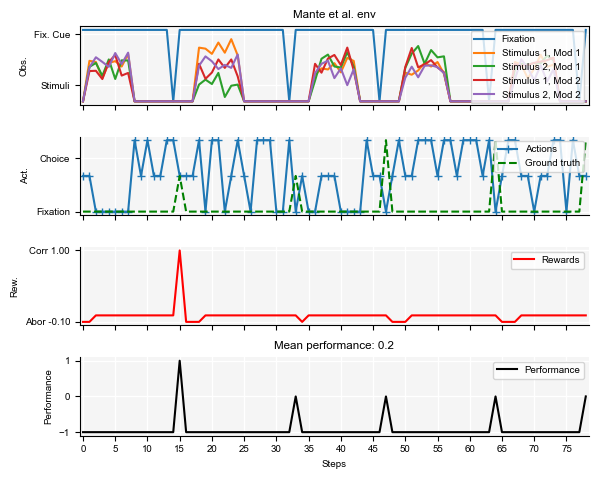

In [ ]:
import neurogym as ngym
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Create the environment
task = "ContextDecisionMaking"
env = gym.make(task)
# Check the custom environment and output additional warnings (if any)
check_env(env)

# Test environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # Random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env.timing)
print("\nObservation space structure:")
print(env.observation_space)
print("Observation components:")
print(env.observation_space.name)
print("\nAction space structure:")
print(env.action_space)
print("Action mapping:")
print(env.action_space.name)

# Visualize example trials
fig = ngym.utils.plot_env(
    env,
    name='Mante et al.',
    ob_traces=[
        'Fixation',
        'Stimulus 1, Mod 1',  # First stimulus component of modality 1
        'Stimulus 2, Mod 1',  # Second stimulus component of modality 1
        'Stimulus 1, Mod 2',  # First stimulus component of modality 2
        'Stimulus 2, Mod 2',  # Second stimulus component of modality 2
    ],
    num_trials=5
)

# TODO: How do we show an average metrics of performance? Just the performance plotted? How many trials are needed? Also note that performance here is computed only whene there is ground truth, this overestimates it since also an action made when there is no ground truth should be penalized with lower performance
# TODO: What is the meaning of the fixation signal here? It is always high except for when there is the ground truth
# TODO: Failing to maintain fixation should lead to aborted trials (also in the code it's like this). I think we should use terminated/truncated conditions instead of other vars. If you look at the plots, this does not seem to happen (I think there is a bug, might be related to the handling of new_trial instead of the former done - now terminated/truncated)

Looking at these initial trials with a random agent, we can observe that:

- The agent takes arbitrary actions regardless of the stimulus presented (random choices)
- It has no understanding that modality 1 is the relevant one for making correct choices
- It often fails to maintain fixation when required, leading to aborted trials
- Performance bounces between 0 (incorrect choices) and 1 (correct choices by chance), with -1 shown during the trial before a choice is made. The mean performance over time confirms the agent is performing at chance level.

This random behavior serves as our baseline. Through training, we expect the agent to learn to maintain fixation during the fixation and stimulus periods, identify modality 1 as the relevant input, learn the correct mapping between the peaks in modality 1's signal and the appropriate left/right choices, and ignore the signals from modality 2, even when they are strong.

Let's move on to training the agent to see if it can learn these key aspects of the task.


## Part 2: Training and Evaluating the Agent

After seeing how a random agent performs, we'll train it using Stable-Baselines3's implementation of PPO (Proximal Policy Optimization). First, let's set up the training infrastructure:

1. `Monitor`: A wrapper that monitors training by:

- Tracking and saving behavioral data (rewards, actions, observations) every `sv_per` steps
- Generating visualization figures during training if `sv_fig=True`
- Providing progress information if `verbose=True`
  This will help us assess the learning process and save intermediate results.

2. `DummyVecEnv`: A Stable-Baselines3 wrapper that converts our environment into a vectorized form (required by PPO), even though we're only using a single environment instance.

Let's train our agent:


Using cpu device


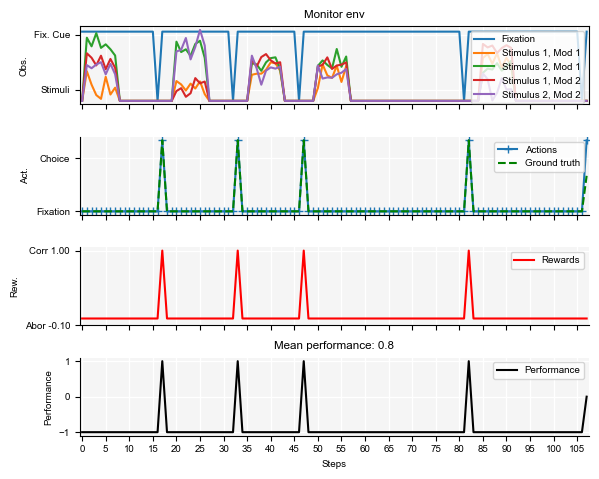

In [ ]:
from stable_baselines3 import PPO
from neurogym.wrappers import monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Environment parameters
# These are the default values, shown here to demonstrate how they can be modified:
dt = 100
use_expl_context = False
impl_context_modality = 0
impl_dim_ring = 2
rewards = {
   "abort": -0.1,
   "correct": +1.0,
   "fail": 0.0
}
timing = {
   "fixation": 300,
   "stimulus": 750,
   "delay": 0,
   "decision": 100,
}
sigma = 1.0
# We can modify any of these parameters by passing them to gym.make():
kwargs = {
   # "dt": dt,
   # "use_expl_context": use_expl_context,
   # "impl_context_modality": impl_context_modality,
   # "impl_dim_ring": impl_dim_ring,
   # "rewards": rewards,
   # "timing": timing,
   # "sigma": sigma,
}

# Create and wrap the environment
# TODO: How does the environment versioning work?
task = "ContextDecisionMaking"
env = gym.make(task, **kwargs)
# TODO: Check the working of Monitor class
# Monitor wrapper saves training data and can generate figures
env = monitor.Monitor(env,
                     sv_per=10000,        # Save data every 10000 steps
                     verbose=1,           # Print training progress
                     sv_fig=True,         # Save figures during training
                     num_stps_sv_fig=100) # Steps per figure
env_vec = DummyVecEnv([lambda: env])      # Vectorize environment for PPO

# Create and train PPO agent
model = PPO("MlpPolicy", env_vec, verbose=1)
model.learn(total_timesteps=100000, log_interval=1000)
env_vec.close()

# Plot example trials with trained agent
fig = ngym.utils.plot_env(
    env,
    ob_traces=["Fixation",
               "Stimulus 1, Mod 1",   # First stimulus component of modality 1
               "Stimulus 2, Mod 1",   # Second stimulus component of modality 1
               "Stimulus 1, Mod 2",   # First stimulus component of modality 2
               "Stimulus 2, Mod 2"],  # Second stimulus component of modality 2
    num_trials=5,
    model=model,
)

# TODO: do we want to give the possibility to use GPU? In this in the scope of the tutorials for the paper?

After training, we visualize the agent's behavior on several trials. In contrast to the random agent, we should now see:

- Consistent fixation maintenance during the fixation period
- Choices that correlate with the evidence in modality 1 (the relevant modality)
- No systematic relationship between choices and modality 2 signals
- Performance significantly above chance level (0.5)

The plot shows the trained agent's behavior across 5 example trials, allowing us to visualize how well it has learned to selectively integrate information from the relevant modality while ignoring the irrelevant one.


# Learning the Task as a Supervised Problem


## Part 1: Converting the Environment to a Supervised Dataset


## Part 2: Training and Evaluating a Neural Network Model


# Comparing RL and SL Approaches

Ideas: learning performance, training efficiency, behavioral patterns
